# SWMT on shelf for PanAntarctic 1/10th

In [1]:
import intake
import cosima_cookbook as cc
import glob

import cartopy.crs as ccrs
import cf_xarray as cfxr
import cmocean as cm
import dask.distributed
import gsw
import matplotlib.pyplot as plt
from matplotlib import gridspec 
import matplotlib.colors as mcolors
import matplotlib.path as mpath
import numpy as np
import xarray as xr
import pdb
import os
import pathlib
import shutil

import warnings # ignore these warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = UserWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

In [2]:
#Starting a dask client
from os import environ
environ["PYTHONWARNINGS"] = "ignore"

from dask.distributed import Client
client = Client(threads_per_worker = 1)

In [3]:
def get_variables(expt, freq, start_time, end_time, lon_slice, lat_slice, model):

    # The models require different diagnostics to calculate the heat and salt fluxes.
    # mom6 outputs a net flux, whilst with mom5 we need to work with the separate components.
    model_vars = {
                    "mom5": {
                        "temperature":           ["temp"],
                        "salinity":              ["salt"],
                        "water_flux_into_ocean": ["pme_river"],
                        "salt_flux":             ["sfc_salt_flux_ice", "sfc_salt_flux_restore"],
                        "heat_flux":             ["sfc_hflux_coupler", "sfc_hflux_from_runoff",
                                                  "frazil_3d_int_z", "sfc_hflux_pme"],
                        "area":                  ["area_t"],
                        "maximum_depth":         ["ht"],
                    },
                    "mom6": {
                        "temperature":           ["thetao"],
                        "salinity":              ["so"],
                        "water_flux_into_ocean": ["wfo"],
                        "salt_flux":             ["salt_flux"],
                        "heat_flux":             ["hfds"],
                        "area":                  ["areacello"],
                        "maximum_depth":         ["deptho"],
                    }
                }
    # Load variables in a dictionary
    ds = {}
    keys = list(model_vars[model].keys())
    for k in keys:
        ds[k] = {}
        for var in model_vars[model][k]:
            if k in ["area", "maximum_depth"]:
                ds[k][var] = cc.querying.getvar(expt, var, session, n = 1) 
                ds[k][var] = ds[k][var].cf.sel(X = lon_slice, Y = lat_slice)
            else:
                try:
                    ds[k][var] = cc.querying.getvar(expt, var, session,
                                                frequency = freq,
                                                start_time = start_time,
                                                end_time = end_time,
                                                chunks = {'time': 1})
                    ds[k][var] = ds[k][var].cf.sel(X = lon_slice, Y = lat_slice, time = slice(start_time, end_time))
                
                    # Correct temperatures (if in K convert to C)
                    if k == 'temperature' and np.max(ds[k][var]) > 100:
                        ds[k][var] = ds[k][var] - 273.15
    
                    # If 3D field, grab the surface
                    if ds[k][var].cf.axes.get('Z'):
                        surface_z = ds[k][var].cf['Z'][0].values
                        ds[k][var] = ds[k][var].cf.sel(Z = 0, method = 'nearest')
                except Exception as e:
                    raise Exception(f"Data loading error: var={var}, freq={freq}, start_time={start_time}, end_time={end_time}, expt={expt}: {str(e)}")

    # Get temperature and salinity to calculate few other things we'll need later on
    SP = ds['salinity'][model_vars[model]['salinity'][0]]
    CT = ds['temperature'][model_vars[model]['temperature'][0]]

    # Calculate pressure
    pressure = gsw.p_from_z(-surface_z, SP.cf['Y']).rename('pressure')

    # Calculate absolute salinity
    SA = gsw.SA_from_SP(SP, pressure, SP.cf['X'], SP.cf['Y']).rename('SA')

    # Ensure we have conservative temperature; Convert MOM6's potential temperature to conservative
    if model == 'mom6':
        CT = gsw.CT_from_pt(SA, CT)
        ds['temperature'][model_vars[model]['temperature'][0]].data = CT.values

    # Calculate potential density
    pot_rho_0 = gsw.sigma0(SA, CT)#.rename('pot_rho_11')

    # Save everything to our dictionary
    ds['pressure'] = pressure
    ds['SA'] = SA
    ds['pot_rho_0'] = pot_rho_0
    
    # Calculate days per month accounting for leap years
    months_standard_noleap = np.array([31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    months_standard_leap = np.array([31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31])
    if 'ryf' or 'panan' in expt:
        nyears = len(np.unique(CT['time.year']))
        days_per_month = np.tile(months_standard_noleap, nyears)
    elif 'iaf' in expt:
        nyears = len(np.unique(CT['time.year']))
        if CT['time.year'][0] % 4 == 0:
            days_per_month = months_standard_leap
        else: 
            days_per_month = months_standard_noleap
        for yr in CT['time.year'][::12][1:]:
            if yr % 4 == 0:
                days_per_month = np.concatenate([days_per_month, months_standard_leap])
            else:
                days_per_month = np.concatenate([days_per_month, months_standard_noleap])
    days_per_month = xr.DataArray(days_per_month, dims = ['time'], coords = {'time': CT['time']}, name = 'days_per_month')
    ds['days_per_month'] = days_per_month

    return ds

In [4]:
def compute_salt_transformation(ds):
    
    # First retrieve temperature and water_flux as an xarray instead of a dictionary
    CT = xr.Dataset(ds['temperature']).to_array().squeeze().drop_vars('variable')

    # Multiply the water flux by absolute salinity to get it in the correct units
    water_flux_into_ocean = xr.Dataset(ds['water_flux_into_ocean']).to_array().squeeze().drop_vars('variable')
    water_flux_into_ocean = ds['SA'] * water_flux_into_ocean

    # Caculate the haline contraction coefficient
    haline_contraction = gsw.beta(ds['SA'], CT, ds['pressure']).rename('beta')

    # Calculate the net salt flux and multiply by 1000 to convert units
    net_salt_flux = xr.Dataset(ds['salt_flux']).to_array().sum(dim = 'variable') * 1000

    # Note that we also multiply pme_river by absolute salinity to have the correct units
    salt_transformation = haline_contraction * (water_flux_into_ocean - net_salt_flux) * ds['days_per_month']
    salt_transformation = salt_transformation.load()

    return salt_transformation

def compute_heat_transformation(ds):

    # First retrieve temperature as an xarray instead of a dictionary
    CT = xr.Dataset(ds['temperature']).to_array().squeeze().drop_vars('variable')

    # Calculate the thermal expansion coefficient 
    thermal_expansion = gsw.alpha(ds['SA'], CT, ds['pressure']).rename('alpha')
    
    # Calculate the net surface heating
    net_surface_heating = xr.Dataset(ds['heat_flux']).to_array().sum(dim = 'variable')
    
    # Calculate the heat transformation
    heat_transformation = thermal_expansion * net_surface_heating * ds['days_per_month']
    heat_transformation = heat_transformation.load()

    return heat_transformation

In [5]:
def isopycnal_bins(ds, salt_transformation, heat_transformation):

    # Next section does a few things. It cycles through isopycnal bins, determines which cells are 
    # within the given bin for each month, finds the transformation values for those cells for each month, 
    # and sums these through time. You are left with an array of shape (isopyncal bins * lats * lons) 
    # where the array associated with a given isopycnal bin is NaN everywhere except where pot_rho_0
    # was within the bin, there it has a time summed transformation value.
    
    # Choose appropriate bin range
    # isopycnal_bins = np.arange(31, 33.5, 0.02)  # 125 bins - 31, 33.5, 0.02 (sigma1)
    isopycnal_bins = np.concatenate([np.arange(25.0, 26.5, 0.05), np.arange(26.5, 28.5, 0.02)])  # 130 bins (sigma0)
    bin_bottoms = isopycnal_bins[:-1]
    isopycnal_bin_mid = (isopycnal_bins[1:] + bin_bottoms) / 2
    isopycnal_bin_diff = np.diff(isopycnal_bins)

    pot_rho_0 = ds['pot_rho_0']

    results_salt = []
    results_heat = []

    for i in range(len(bin_bottoms)):
        # Create binary mask for each bin
        bin_mask = xr.where((pot_rho_0 > bin_bottoms[i]) & (pot_rho_0 <= isopycnal_bins[i + 1]), 1, np.nan)

        # Multiply and sum over time
        salt_sum = (salt_transformation * bin_mask).sum(dim='time')
        heat_sum = (heat_transformation * bin_mask).sum(dim='time')

        results_salt.append(salt_sum.expand_dims({'isopycnal_bins': [isopycnal_bin_mid[i]]}))
        results_heat.append(heat_sum.expand_dims({'isopycnal_bins': [isopycnal_bin_mid[i]]}))

    # Concatenate results along isopycnal dimension
    salt_transformation = xr.concat(results_salt, dim='isopycnal_bins')
    heat_transformation = xr.concat(results_heat, dim='isopycnal_bins')

    # Normalise by number of days and bin thickness
    ndays = ds['days_per_month'].sum()
    c_p = 3992.1 # J kg-1 degC-1

    salt_transformation /= ndays
    heat_transformation /= (c_p * ndays)

    salt_transformation /= isopycnal_bin_diff[:, np.newaxis, np.newaxis]
    heat_transformation /= isopycnal_bin_diff[:, np.newaxis, np.newaxis]

    # Overwrite zeros with NANs 
    # (Note: the code within the for-loop should provide nans but lazy computing with dask can sometimes give unpredictable results)
    salt_transformation = salt_transformation.where(salt_transformation != 0)
    heat_transformation = heat_transformation.where(heat_transformation != 0)

    # Change the sign so that positive means conversion into denser water masses
    salt_transformation *= -1
    heat_transformation *= -1

    # Renaming
    salt_transformation.name = "salt_transformation"
    heat_transformation.name = "heat_transformation"

    return salt_transformation.load(), heat_transformation.load()

## Opening the saved data

In [6]:
# Importing the saved files
salt_files_C = np.sort(glob.glob('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_C_*'))
heat_files_C = np.sort(glob.glob('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_C_*'))

salt_files_M = np.sort(glob.glob('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_M_*'))
heat_files_M = np.sort(glob.glob('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_M_*'))

In [7]:
salt_tr_C = xr.open_mfdataset(salt_files_C, concat_dim='time', combine='nested', chunks={'time': 1, 'yh': 100, 'xh': 100})
heat_tr_C = xr.open_mfdataset(heat_files_C, concat_dim='time', combine='nested', chunks={'time': 1, 'yh': 100, 'xh': 100})
salt_tr_C = salt_tr_C.to_array().squeeze()
heat_tr_C = heat_tr_C.to_array().squeeze()

In [8]:
salt_tr_C

<xarray.DataArray (time: 10, isopycnal_bins: 129, yh: 510, xh: 3600)> Size: 19GB
dask.array<getitem, shape=(10, 129, 510, 3600), dtype=float64, chunksize=(1, 129, 100, 100), chunktype=numpy.ndarray>
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 1kB 25.02 25.08 ... 28.45 28.47
  * xh              (xh) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yh              (yh) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
    z_l             float64 8B 0.5413
    variable        <U19 76B 'salt_transformation'
Dimensions without coordinates: time

In [9]:
salt_tr_M = xr.open_mfdataset(salt_files_M, concat_dim='time', combine='nested', chunks={'time': 1, 'yh': 100, 'xh': 100})
heat_tr_M = xr.open_mfdataset(heat_files_M, concat_dim='time', combine='nested', chunks={'time': 1, 'yh': 100, 'xh': 100})
salt_tr_M = salt_tr_M.to_array().squeeze()
heat_tr_M = heat_tr_M.to_array().squeeze()

In [10]:
net_tr_C = salt_tr_C + heat_tr_C
net_tr_M = salt_tr_M + heat_tr_M

In [11]:
# Defining the data separately for variables like area, depth, etc.
expt_con = 'panant-01-zstar-ACCESSyr2'
db = '/home/272/kc5856/databases/honours_new.db'
session = cc.database.create_session(db)
freq = '1 monthly'

lon_slice = slice(None, None)
lat_slice = slice(None, -59)

start_time = '2001-01-01'
end_time = '2001-12-31'

ds_cont = get_variables(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')

In [12]:
print(ds_cont['pot_rho_0'].min().values, ds_cont['pot_rho_0'].max().values)

6.607014766692146 29.583969164554446


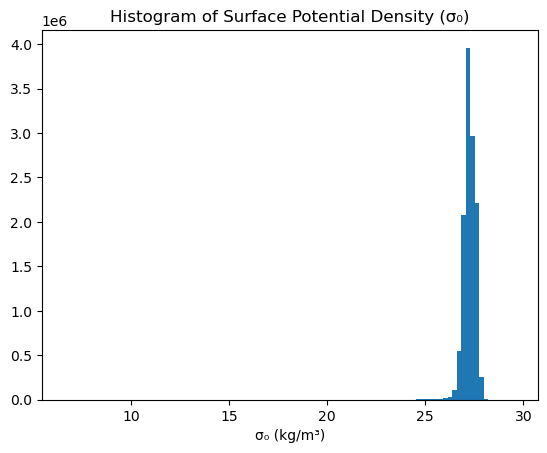

In [13]:
# Plot histogram to confirm valid range
ds_cont['pot_rho_0'].plot.hist(bins=100)
plt.xlabel("σ₀ (kg/m³)")
plt.title("Histogram of Surface Potential Density (σ₀)")
plt.show()

In [14]:
valid_pot_rho_0 = ds_cont['pot_rho_0'].where(ds_cont['pot_rho_0'] > 20)  # mask out junk values

print("Min:", valid_pot_rho_0.min().values)
print("Max:", valid_pot_rho_0.max().values)

Min: 20.001611749106132
Max: 29.583969164554446


#### Antarctic shelf dense water formation

In [15]:
def shelf_mask_isobath(var, model_dict):

    paths = {
             "mom5": "/g/data/ik11/grids/Antarctic_slope_contour_1000m.npz",
             "mom6_01": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_01deg.nc",
            "mom6_005": "/g/data/ik11/grids/Antarctic_slope_contour_1000m_MOM6_005deg.nc"
             }

    var = var.cf.sel({'latitude': slice(-90, -59)})

    if paths[model_dict][-3:] == '.nc':
        shelf_mask = xr.open_dataset(paths[model_dict])['contour_masked_above']
    else:
        contour_file = np.load(paths[model_dict])
        shelf_mask = xr.DataArray(contour_file['contour_masked_above'],
                                  coords = var.coords, 
                                  dims = var.dims,
                                  name = 'contour_masked_above')
    
    shelf_mask = xr.where(shelf_mask == 0, 1, 0)
    masked_var = var * shelf_mask
    
    return masked_var, shelf_mask

In [16]:
depth = xr.Dataset(ds_cont['maximum_depth']).to_array().squeeze()
land_mask = (0 * depth).fillna(1)
depth_shelf, shelf_mask = shelf_mask_isobath(depth, 'mom6_01')

In [17]:
area = xr.Dataset(ds_cont['area']).to_array().squeeze().drop_vars('variable')
varr = xr.Dataset(ds_cont['salinity']).to_array().squeeze().isel(time=0)
area_corr = (area*(varr*0+1)).drop_vars('variable')

In [18]:
area_corr = area_corr.drop_vars(['time','z_l'])

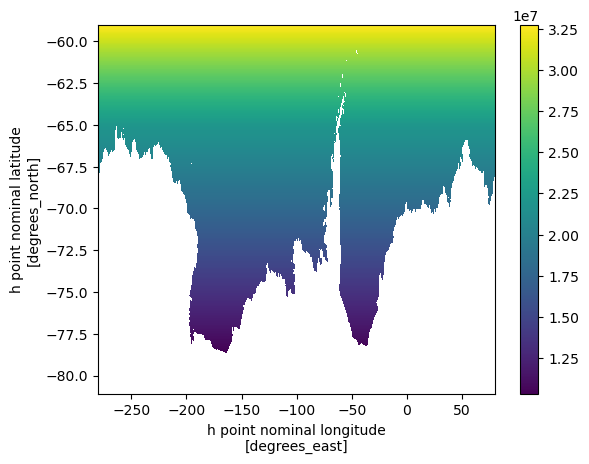

In [19]:
# Check mask
area_corr.plot()

Corrected area not needed because it is already being multiplied with a variable with the correct mask below?

In [20]:
swmt_shelf_C = (net_tr_C * area_corr / 1e6).where(shelf_mask == 1)
heat_shelf_C = (heat_tr_C * area_corr / 1e6).where(shelf_mask == 1)
salt_shelf_C = (salt_tr_C * area_corr / 1e6).where(shelf_mask == 1)

swmt_shelf_C = swmt_shelf_C.chunk({'time': 1, 'yh': 100, 'xh': 100})
heat_shelf_C = heat_shelf_C.chunk({'time': 1, 'yh': 100, 'xh': 100})
salt_shelf_C = salt_shelf_C.chunk({'time': 1, 'yh': 100, 'xh': 100})

In [21]:
#swmt_shelf_C.cf.sum(['xh', 'yh']).astype('float32') # if needed

In [22]:
swmt_shelf_sum_C = swmt_shelf_C.cf.sum(['xh', 'yh']).compute()

2025-08-03 21:49:40,472 - distributed.worker - ERROR - failed during get data with tcp://127.0.0.1:36401 -> tcp://127.0.0.1:43469
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/tornado/iostream.py", line 861, in _read_to_buffer
    bytes_read = self.read_from_fd(buf)
                 ^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/tornado/iostream.py", line 1116, in read_from_fd
    return self.socket.recv_into(buf, len(buf))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TimeoutError: [Errno 110] Connection timed out

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-24.07/lib/python3.11/site-packages/distributed/worker.py", line 1797, in get_data
    response = await comm.read(deserializers=serializers)
               ^^^^^^^

In [23]:
# Time mean
swmt_shelf_sum_ave_C = swmt_shelf_sum_C.mean(dim='time')

for da in [swmt_shelf_sum_ave_C]:#, heat_shelf_sum_ave_C, salt_shelf_sum_ave_C]:
    da.attrs["units"] = "Sv"

In [24]:
swmt_shelf_M = (net_tr_M * area_corr / 1e6).where(shelf_mask == 1)
heat_shelf_M = (heat_tr_M * area_corr / 1e6).where(shelf_mask == 1)
salt_shelf_M = (salt_tr_M * area_corr / 1e6).where(shelf_mask == 1)

swmt_shelf_M = swmt_shelf_M.chunk({'time': 1, 'yh': 100, 'xh': 100})
heat_shelf_M = heat_shelf_M.chunk({'time': 1, 'yh': 100, 'xh': 100})
salt_shelf_M = salt_shelf_M.chunk({'time': 1, 'yh': 100, 'xh': 100})

In [25]:
swmt_shelf_sum_M = swmt_shelf_M.cf.sum(['xh', 'yh']).compute()

In [26]:
# Time mean
swmt_shelf_sum_ave_M = swmt_shelf_sum_M.mean(dim='time')

for da in [swmt_shelf_sum_ave_M]: #, heat_shelf_sum_ave_M, salt_shelf_sum_ave_M]:
    da.attrs["units"] = "Sv"

In [27]:
swmt_shelf_sum_ave_C # check

<xarray.DataArray (isopycnal_bins: 129)> Size: 1kB
array([-1.66702720e-01, -1.50699551e-01, -1.64629721e-01, -1.61588627e-01,
       -1.75954759e-01, -1.73355005e-01, -1.53502340e-01, -1.64354798e-01,
       -1.51119817e-01, -1.35747022e-01, -1.53644491e-01, -1.50294928e-01,
       -1.36863423e-01, -1.48160058e-01, -1.39973778e-01, -1.34309690e-01,
       -1.24983391e-01, -1.35389155e-01, -1.39025020e-01, -1.33203324e-01,
       -1.62846545e-01, -1.33722247e-01, -1.00567959e-01, -8.85609757e-02,
       -1.22570314e-01, -1.31613566e-01, -1.76152670e-01, -2.19640195e-01,
       -2.68420152e-01, -2.52981429e-01, -2.62534484e-01, -2.55674819e-01,
       -2.38410376e-01, -2.56629338e-01, -2.78590157e-01, -3.25463738e-01,
       -3.62021768e-01, -4.53595545e-01, -4.50089678e-01, -4.19289403e-01,
       -3.86523621e-01, -4.08349794e-01, -4.32521747e-01, -4.49995708e-01,
       -5.52010403e-01, -6.96811008e-01, -7.24507964e-01, -5.02039840e-01,
       -3.18291091e-01, -3.15630241e-01, -3.43439460e-01, -3.80962772e-01,
       -4.30149488e-01, -4.07713752e-01, -2.93719785e-01, -4.67639117e-02,
        5.25079957e-02,  8.78024443e-02,  7.49391805e-02,  1.88431952e-01,
        2.81897509e-01,  2.24983192e-01,  2.36426848e-01,  2.03673315e-01,
        3.51360323e-01,  5.41498190e-01,  7.08982565e-01,  8.62610936e-01,
        1.12574455e+00,  1.46116477e+00,  1.82414123e+00,  2.05997003e+00,
        2.19756819e+00,  2.44624769e+00,  2.65331951e+00,  2.87694679e+00,
        3.09223739e+00,  3.39966983e+00,  3.69926709e+00,  4.48941310e+00,
        4.93961903e+00,  5.37108213e+00,  5.85373289e+00,  6.14215373e+00,
        6.54935674e+00,  7.14115900e+00,  7.68595111e+00,  7.94349120e+00,
        7.75409386e+00,  7.69404191e+00,  6.51679833e+00,  5.95475626e+00,
        5.51549801e+00,  4.78051854e+00,  4.77210303e+00,  4.20501793e+00,
        3.27165048e+00,  2.58944697e+00,  2.20926090e+00,  2.03716674e+00,
        1.74948479e+00,  1.60621913e+00,  1.29530843e+00,  1.21097783e+00,
        9.04060563e-01,  8.22388600e-01,  4.73648178e-01,  1.62535575e-01,
        3.63241503e-02,  2.12203955e-02,  2.36289067e-02,  1.75177920e-02,
        1.65259495e-02,  1.37288436e-02,  1.33860142e-02,  1.31338974e-02,
        1.00977665e-02,  1.29201553e-02,  7.99290760e-03,  8.33440910e-03,
        8.01981731e-03,  8.20468120e-03,  8.49080385e-03,  5.90077640e-03,
        7.50534933e-03,  3.95898868e-03,  8.60803987e-03,  5.97100394e-03,
        3.98828906e-03])
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 1kB 25.02 25.08 ... 28.45 28.47
    z_l             float64 8B 0.5413
Attributes:
    units:    Sv

In [28]:
swmt_shelf_sum_ave_C.compute()

<xarray.DataArray (isopycnal_bins: 129)> Size: 1kB
array([-1.66702720e-01, -1.50699551e-01, -1.64629721e-01, -1.61588627e-01,
       -1.75954759e-01, -1.73355005e-01, -1.53502340e-01, -1.64354798e-01,
       -1.51119817e-01, -1.35747022e-01, -1.53644491e-01, -1.50294928e-01,
       -1.36863423e-01, -1.48160058e-01, -1.39973778e-01, -1.34309690e-01,
       -1.24983391e-01, -1.35389155e-01, -1.39025020e-01, -1.33203324e-01,
       -1.62846545e-01, -1.33722247e-01, -1.00567959e-01, -8.85609757e-02,
       -1.22570314e-01, -1.31613566e-01, -1.76152670e-01, -2.19640195e-01,
       -2.68420152e-01, -2.52981429e-01, -2.62534484e-01, -2.55674819e-01,
       -2.38410376e-01, -2.56629338e-01, -2.78590157e-01, -3.25463738e-01,
       -3.62021768e-01, -4.53595545e-01, -4.50089678e-01, -4.19289403e-01,
       -3.86523621e-01, -4.08349794e-01, -4.32521747e-01, -4.49995708e-01,
       -5.52010403e-01, -6.96811008e-01, -7.24507964e-01, -5.02039840e-01,
       -3.18291091e-01, -3.15630241e-01, -3.43439460e-01, -3.80962772e-01,
       -4.30149488e-01, -4.07713752e-01, -2.93719785e-01, -4.67639117e-02,
        5.25079957e-02,  8.78024443e-02,  7.49391805e-02,  1.88431952e-01,
        2.81897509e-01,  2.24983192e-01,  2.36426848e-01,  2.03673315e-01,
        3.51360323e-01,  5.41498190e-01,  7.08982565e-01,  8.62610936e-01,
        1.12574455e+00,  1.46116477e+00,  1.82414123e+00,  2.05997003e+00,
        2.19756819e+00,  2.44624769e+00,  2.65331951e+00,  2.87694679e+00,
        3.09223739e+00,  3.39966983e+00,  3.69926709e+00,  4.48941310e+00,
        4.93961903e+00,  5.37108213e+00,  5.85373289e+00,  6.14215373e+00,
        6.54935674e+00,  7.14115900e+00,  7.68595111e+00,  7.94349120e+00,
        7.75409386e+00,  7.69404191e+00,  6.51679833e+00,  5.95475626e+00,
        5.51549801e+00,  4.78051854e+00,  4.77210303e+00,  4.20501793e+00,
        3.27165048e+00,  2.58944697e+00,  2.20926090e+00,  2.03716674e+00,
        1.74948479e+00,  1.60621913e+00,  1.29530843e+00,  1.21097783e+00,
        9.04060563e-01,  8.22388600e-01,  4.73648178e-01,  1.62535575e-01,
        3.63241503e-02,  2.12203955e-02,  2.36289067e-02,  1.75177920e-02,
        1.65259495e-02,  1.37288436e-02,  1.33860142e-02,  1.31338974e-02,
        1.00977665e-02,  1.29201553e-02,  7.99290760e-03,  8.33440910e-03,
        8.01981731e-03,  8.20468120e-03,  8.49080385e-03,  5.90077640e-03,
        7.50534933e-03,  3.95898868e-03,  8.60803987e-03,  5.97100394e-03,
        3.98828906e-03])
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 1kB 25.02 25.08 ... 28.45 28.47
    z_l             float64 8B 0.5413
Attributes:
    units:    Sv

In [29]:
swmt_shelf_sum_ave_M.compute()

<xarray.DataArray (isopycnal_bins: 129)> Size: 1kB
array([-2.20382389e-01, -2.21553084e-01, -2.22522633e-01, -2.24587471e-01,
       -1.96098860e-01, -1.75862660e-01, -2.13555033e-01, -2.10082372e-01,
       -2.04012575e-01, -2.15029669e-01, -2.27579392e-01, -2.29961318e-01,
       -2.05356701e-01, -2.09333759e-01, -2.15234629e-01, -2.00217436e-01,
       -2.03579909e-01, -2.24659543e-01, -2.24083865e-01, -2.21748230e-01,
       -2.16739351e-01, -1.89590174e-01, -1.95223454e-01, -1.90410178e-01,
       -1.95524675e-01, -2.18871735e-01, -2.79798124e-01, -3.22320145e-01,
       -3.35596307e-01, -3.47729468e-01, -3.27965403e-01, -3.28141394e-01,
       -3.18157948e-01, -3.29394063e-01, -3.76216424e-01, -3.44925035e-01,
       -4.31920651e-01, -5.09616970e-01, -4.79529014e-01, -4.68664973e-01,
       -4.49028227e-01, -4.28097078e-01, -4.10257173e-01, -3.83268404e-01,
       -4.30776436e-01, -5.74817962e-01, -5.73114055e-01, -3.76245042e-01,
       -2.05161688e-01, -1.26583081e-01, -1.27161416e-01, -1.56412952e-01,
       -2.33785100e-01, -2.51128421e-01,  2.60331120e-03,  2.12217762e-01,
        2.73353395e-01,  2.76206845e-01,  4.30829695e-01,  5.91531138e-01,
        6.06560794e-01,  6.67950698e-01,  6.41891252e-01,  6.72148264e-01,
        7.84116503e-01,  9.62012470e-01,  1.19540511e+00,  1.45879680e+00,
        1.68886537e+00,  1.90781390e+00,  2.05612584e+00,  2.26455890e+00,
        2.61414141e+00,  2.93187252e+00,  2.89063567e+00,  3.14981325e+00,
        3.50290332e+00,  3.79683936e+00,  4.23070511e+00,  4.72714246e+00,
        5.20290265e+00,  5.59568826e+00,  5.93570532e+00,  6.40016043e+00,
        6.97726909e+00,  7.40716007e+00,  7.75542545e+00,  7.55033426e+00,
        7.45386181e+00,  6.54358718e+00,  5.83091620e+00,  5.43612061e+00,
        4.79037992e+00,  4.56497650e+00,  3.99975566e+00,  3.20599703e+00,
        2.50004715e+00,  2.10682143e+00,  1.87417714e+00,  1.75511181e+00,
        1.53817886e+00,  1.35399364e+00,  1.08543448e+00,  8.37573604e-01,
        5.48927094e-01,  2.47506740e-01,  6.46316227e-02,  1.56691465e-02,
        1.30384911e-02,  9.13582032e-03,  1.13835431e-02,  1.09460867e-02,
        7.75041541e-03,  7.09687927e-03,  5.45064101e-03,  5.17225276e-03,
        4.83987801e-03,  4.62557476e-03,  3.29729827e-03,  4.30294799e-03,
        1.98978950e-03,  3.31350311e-03,  4.00445342e-03,  3.48581053e-03,
        2.83034221e-03,  2.74990107e-03,  2.66194531e-03,  1.56335913e-03,
        1.02430386e-03])
Coordinates:
  * isopycnal_bins  (isopycnal_bins) float64 1kB 25.02 25.08 ... 28.45 28.47
    z_l             float64 8B 0.5413
Attributes:
    units:    Sv

In [71]:
# 25% and 75% thresholds
## Replace when using new data
cont_d25 = 27.89
cont_d75 = 27.73 #done

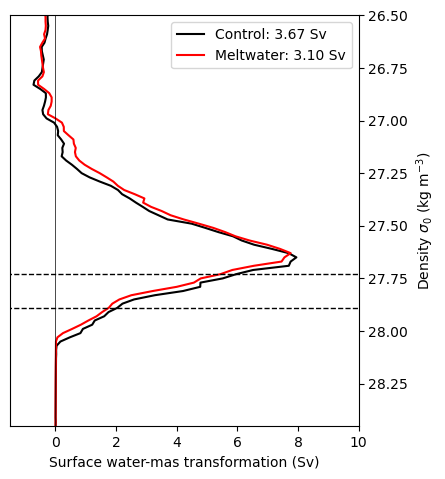

In [85]:
fig, ax1 = plt.subplots(figsize=(4.5, 5.33))

ax1.plot(swmt_shelf_sum_ave_C, swmt_shelf_sum_ave_C['isopycnal_bins'], color = 'k', label='Control: 3.67 Sv')
ax1.plot(swmt_shelf_sum_ave_M, swmt_shelf_sum_ave_M['isopycnal_bins'], color = 'r', label='Meltwater: 3.10 Sv')
ax1.plot([0, 0], [26.5,28.49], 'k', linewidth=0.5)
ax1.plot([-5, 15], [cont_d25, cont_d25], 'k--', linewidth=1)
ax1.plot([-5, 15], [cont_d75, cont_d75], 'k--', linewidth=1)
ax1.set_ylim((28.45, 26.5))
ax1.set_xlim((-1.5, 10))
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.set_ylabel('Density $\sigma_0$ (kg m$^{-3}$)')
ax1.set_xlabel('Surface water-mas transformation (Sv)')
ax1.legend();

In [40]:
swmt_shelf_sum_ave_C.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/plots/swmt_shelf_sum_ave_rho0_C_pan01.nc')
swmt_shelf_sum_ave_M.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/plots/swmt_shelf_sum_ave_rho0_M_pan01.nc')

#### Old plot with pot_rho_1 for reference

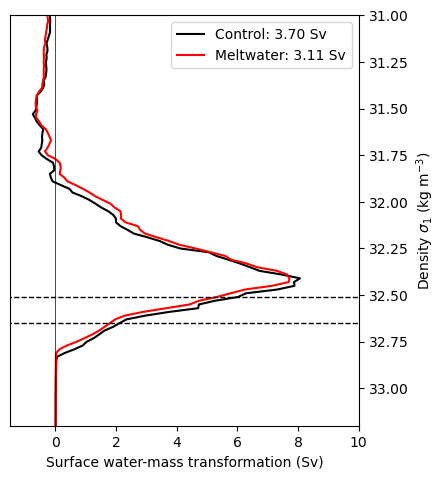

In [30]:
fig, ax1 = plt.subplots(figsize=(4.5, 5.33))

ax1.plot(swmt_shelf_sum_ave_C, swmt_shelf_sum_ave_C['isopycnal_bins'], color = 'k', label='Control: 3.70 Sv')
ax1.plot(swmt_shelf_sum_ave_M, swmt_shelf_sum_ave_M['isopycnal_bins'], color = 'r', label='Meltwater: 3.11 Sv')
ax1.plot([0, 0], [31, 33.2], 'k', linewidth=0.5)
ax1.plot([-5, 15], [cont_d25, cont_d25], 'k--', linewidth=1)
ax1.plot([-5, 15], [cont_d75, cont_d75], 'k--', linewidth=1)
ax1.set_ylim((33.2, 31))
ax1.set_xlim((-1.5, 10))
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
ax1.set_ylabel('Density $\sigma_1$ (kg m$^{-3}$)')
ax1.set_xlabel('Surface water-mass transformation (Sv)')
ax1.legend();

#### SWMT map

In [33]:
transformation_density = 32.58 ## Replace when using new data
shelf_subduction_plot_C = net_tr_C.sel(isopycnal_bins = transformation_density, method = 'nearest') * 1e5
swmt_xt_C = depth.cf['X']
swmt_yt_C = depth.cf['Y']

shelf_subduction_plot_M = net_tr_M.sel(isopycnal_bins = transformation_density, method = 'nearest') * 1e5
swmt_xt_M = depth.cf['X']
swmt_yt_M = depth.cf['Y']

In [34]:
shelf_subduction_plot_C.astype('float32').compute()

<xarray.DataArray (time: 10, yh: 510, xh: 3600)> Size: 73MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    isopycnal_bins  float64 8B 32.59
  * xh              (xh) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yh              (yh) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
    z_l             float64 8B 0.5413
Dimensions without coordinates: time

In [35]:
shelf_subduction_plot_M.astype('float32').compute()

<xarray.DataArray (time: 10, yh: 510, xh: 3600)> Size: 73MB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    isopycnal_bins  float64 8B 32.59
  * xh              (xh) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yh              (yh) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
    z_l             float64 8B 0.5413
Dimensions without coordinates: time

In [36]:
anom_xt = swmt_xt_M.fillna(0) - swmt_xt_C.fillna(0)
anom_yt = swmt_yt_M.fillna(0) - swmt_yt_C.fillna(0)
shelf_subduction_plot_anom = shelf_subduction_plot_M.fillna(0) - shelf_subduction_plot_C.fillna(0)

In [37]:
# Taking time means
shelf_subduction_plot_ave_anom = shelf_subduction_plot_anom.mean(dim='time')
shelf_subduction_plot_ave_anom

<xarray.DataArray (yh: 510, xh: 3600)> Size: 15MB
dask.array<mean_agg-aggregate, shape=(510, 3600), dtype=float64, chunksize=(100, 100), chunktype=numpy.ndarray>
Coordinates:
    isopycnal_bins  float64 8B 32.59
  * xh              (xh) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yh              (yh) float64 4kB -81.11 -81.07 -81.02 ... -59.08 -59.03
    z_l             float64 8B 0.5413

In [38]:
shelf_subduction_plot_ave_anom = shelf_subduction_plot_ave_anom.load()

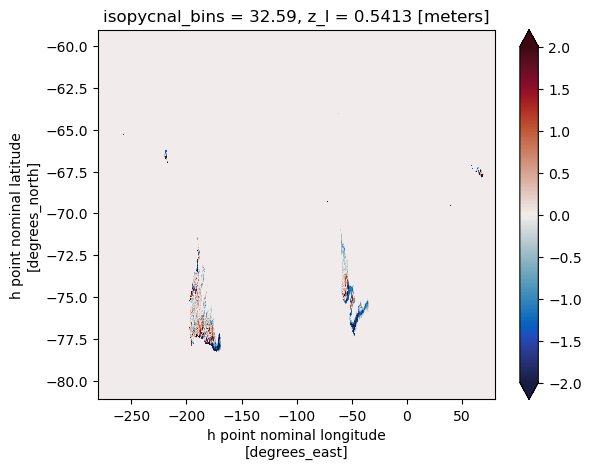

In [39]:
# Check before saving
shelf_subduction_plot_ave_anom.plot(vmin=-2,vmax=2, cmap=cm.cm.balance)

In [44]:
shelf_subduction_plot_ave_anom.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf/plots/swmt_shelf_plot_anom_pan01.nc')

### Finding the 25% and 75%

Control max = 7.9434912 Sv..  
- 25% of max (~1.9858728 Sv) = occurs at 27.89
- 75% of max (~5.9576184 Sv) = occurs at 27.73

Finding the means in this region:
- Mean of control in this slice = **3.67258282 Sv**.
- Mean of meltwater in this region = **3.09965833 Sv**.

We just use the control lines as our formation region. 

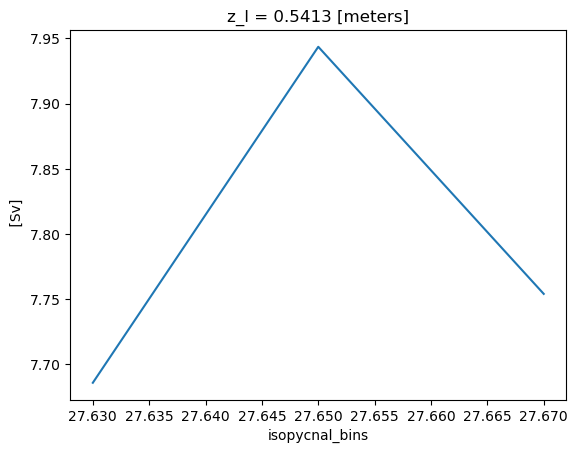

In [44]:
# Finding maximum
swmt_shelf_sum_ave_C.sel(isopycnal_bins=slice(27.62,27.68)).plot() # Pick slice based on plot, test for max value

In [70]:
max_value = 27.88
swmt_shelf_sum_ave_C.sel(isopycnal_bins=str(max_value),method='nearest').load()

<xarray.DataArray ()> Size: 8B
array(2.03716674)
Coordinates:
    isopycnal_bins  float64 8B 27.89
    z_l             float64 8B 0.5413
Attributes:
    units:    Sv

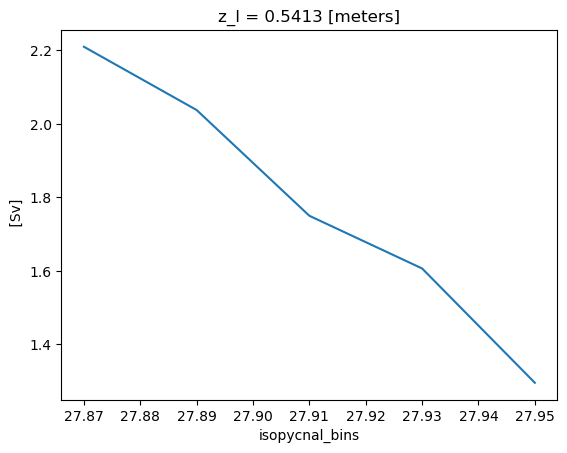

In [66]:
# Finding the 25 and 75
# Finding maximum
swmt_shelf_sum_ave_C.sel(isopycnal_bins=slice(27.85,27.95)).plot() # Pick slice based on plot, test for max value

Finding the sums: (change density values below to match 25 and 75 thresholds)

In [77]:
val_25 = 27.89
val_75 = 27.73

In [74]:
# Control mean
swmt_shelf_sum_ave_C.sel(isopycnal_bins=slice(val_75,val_25)).compute().mean()

<xarray.DataArray ()> Size: 8B
array(3.67258282)
Coordinates:
    z_l      float64 8B 0.5413

In [75]:
# Melt mean
swmt_shelf_sum_ave_M.sel(isopycnal_bins=slice(val_75,val_25)).compute().mean()

<xarray.DataArray ()> Size: 8B
array(3.09965833)
Coordinates:
    z_l      float64 8B 0.5413

#### Time series

In [78]:
swmt_shelf_time_C = swmt_shelf_sum_C.sel(isopycnal_bins=slice(val_75,val_25)).mean('isopycnal_bins').compute()

In [79]:
swmt_shelf_time_M = swmt_shelf_sum_M.sel(isopycnal_bins=slice(val_75,val_25)).mean('isopycnal_bins').compute()

Text(0.5, 1.0, 'Panan01 Surface Water Mass Transformation over 25-75% range')

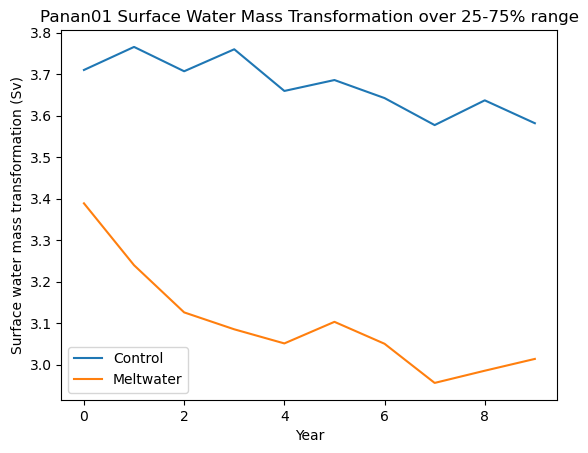

In [80]:
swmt_shelf_time_C.plot(label="Control")
swmt_shelf_time_M.plot(label="Meltwater")
plt.ylabel("Surface water mass transformation (Sv)")
plt.xlabel("Year")
plt.legend(loc="lower left")
plt.title("Panan01 Surface Water Mass Transformation over 25-75% range")

In [81]:
# Saving
swmt_shelf_time_C.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/plots/swmt_shelf_time_pan01_C.nc')
swmt_shelf_time_M.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/plots/swmt_shelf_time_pan01_M.nc')

In [82]:
swmt_shelf_time_anom = swmt_shelf_time_M - swmt_shelf_time_C 

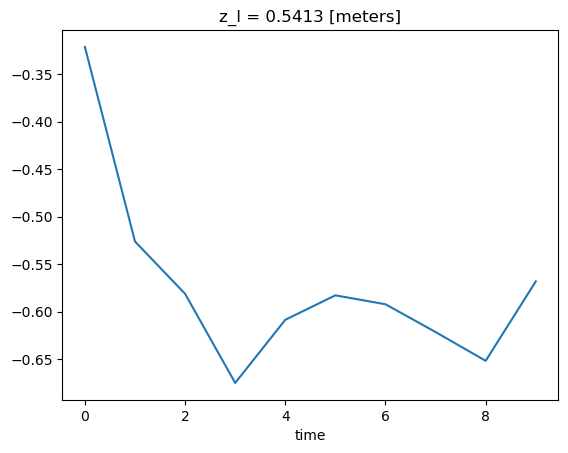

In [83]:
swmt_shelf_time_anom.plot()

In [84]:
swmt_shelf_time_anom.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/plots/swmt_shelf_time_pan01_anom.nc')

## Saving per year via manual method

#### First doing the control

In [6]:
# Change to your experiment of interest
expt_con = 'panant-01-zstar-ACCESSyr2'
db = '/home/272/kc5856/databases/honours_new.db'
session = cc.database.create_session(db)
freq = '1 monthly'

# Select time period and region
lon_slice = slice(None, None)
lat_slice = slice(None, -59)

In [9]:
# Check time slice
start_time = '2001-01-01'
end_time = '2001-12-31'
ds = get_variables(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')

[gadi-cpu-bdw-0252:1597533:0:1597533] Caught signal 11 (Segmentation fault: address not mapped to object at address 0x15068220c5d0)
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_ranges section.
BFD: Dwarf Error: Can't find .debug_

In [7]:
# Painfully manual don't mind this 1

start_time = '2001-01-01'
end_time = '2001-12-31'

ds = get_variables(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_C_01.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_C_01.nc')

In [8]:
# Painfully manual don't mind this 2

start_time = '2002-01-01'
end_time = '2002-12-31'

ds = get_variables(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_C_02.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_C_02.nc')

In [9]:
# Painfully manual don't mind this 3

start_time = '2003-01-01'
end_time = '2003-12-31'

ds = get_variables(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_C_03.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_C_03.nc')

In [10]:
# Painfully manual don't mind this 4

start_time = '2004-01-01'
end_time = '2004-12-31'

ds = get_variables(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_C_04.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_C_04.nc')

In [11]:
# Painfully manual don't mind this 5

start_time = '2005-01-01'
end_time = '2005-12-31'

ds = get_variables(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_C_05.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_C_05.nc')

In [12]:
# Painfully manual don't mind this 6

start_time = '2006-01-01'
end_time = '2006-12-31'

ds = get_variables(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_C_06.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_C_06.nc')

In [13]:
# Painfully manual don't mind this 7

start_time = '2007-01-01'
end_time = '2007-12-31'

ds = get_variables(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_C_07.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_C_07.nc')

In [14]:
# Painfully manual don't mind this 8

start_time = '2008-01-01'
end_time = '2008-12-31'

ds = get_variables(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_C_08.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_C_08.nc')

In [15]:
# Painfully manual don't mind this 9

start_time = '2009-01-01'
end_time = '2009-12-31'

ds = get_variables(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_C_09.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_C_09.nc')

In [16]:
# Painfully manual don't mind this 10

start_time = '2010-01-01'
end_time = '2010-12-31'

ds = get_variables(expt_con, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_C_10.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_C_10.nc')

#### Second doing the perturbation:

In [17]:
# Change to your experiment of interest
expt_melt = 'panant-01-zstar-ssp126-MW-only'
db = '/home/272/kc5856/databases/honours_test.db'
session = cc.database.create_session(db)
freq = '1 monthly'

# Select time period and region
lon_slice = slice(None, None)
lat_slice = slice(None, -59)

In [7]:
# Confirm its working
start_time = '2001-01-01'
end_time = '2001-12-31'
ds = get_variables(expt_melt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
ds

{'temperature': {'thetao': <xarray.DataArray 'thetao' (time: 12, yh: 510, xh: 3600)> Size: 176MB
  array([[[        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          [        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          [        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          ...,
          [-0.53935627, -0.50658415, -0.46190727, ..., -0.54014922,
           -0.5531273 , -0.55464701],
          [-0.50995661, -0.49123733, -0.45902856, ..., -0.49354755,
           -0.51079338, -0.51645104],
          [-0.47490603, -0.46619453, -0.44423261, ..., -0.43135793,
           -0.45628016, -0.47070846]],
  
         [[        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          [        nan,         nan,         nan, ...,         nan,
                   nan,         nan],
          [        nan,         nan,

In [18]:
# Painfully manual don't mind this 1

start_time = '2001-01-01'
end_time = '2001-12-31'

ds = get_variables(expt_melt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_M_01.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_M_01.nc')

In [19]:
# Painfully manual don't mind this 2

start_time = '2002-01-01'
end_time = '2002-12-31'

ds = get_variables(expt_melt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_M_02.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_M_02.nc')

In [20]:
# Painfully manual don't mind this 3

start_time = '2003-01-01'
end_time = '2003-12-31'

ds = get_variables(expt_melt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_M_03.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_M_03.nc')

In [21]:
# Painfully manual don't mind this 4

start_time = '2004-01-01'
end_time = '2004-12-31'

ds = get_variables(expt_melt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_M_04.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_M_04.nc')

In [22]:
# Painfully manual don't mind this 5

start_time = '2005-01-01'
end_time = '2005-12-31'

ds = get_variables(expt_melt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_M_05.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_M_05.nc')

In [23]:
# Painfully manual don't mind this 6

start_time = '2006-01-01'
end_time = '2006-12-31'

ds = get_variables(expt_melt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_M_06.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_M_06.nc')

In [24]:
# Painfully manual don't mind this 7

start_time = '2007-01-01'
end_time = '2007-12-31'

ds = get_variables(expt_melt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_M_07.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_M_07.nc')

In [25]:
# Painfully manual don't mind this 8

start_time = '2008-01-01'
end_time = '2008-12-31'

ds = get_variables(expt_melt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_M_08.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_M_08.nc')

In [ ]:
# Painfully manual don't mind this 9

start_time = '2009-01-01'
end_time = '2009-12-31'

ds = get_variables(expt_melt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_M_09.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_M_09.nc')

In [ ]:
# Painfully manual don't mind this 10

start_time = '2010-01-01'
end_time = '2010-12-31'

ds = get_variables(expt_melt, freq, start_time, end_time, lon_slice, lat_slice, model = 'mom6')
           
salt_transformation = compute_salt_transformation(ds)
heat_transformation = compute_heat_transformation(ds)

salt_transformation_binned, heat_transformation_binned = isopycnal_bins(ds, salt_transformation, heat_transformation)

salt_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_salt_trans_pan01_M_10.nc')
heat_transformation_binned.to_netcdf('/g/data/g40/kc5856/access_panan_ssp126_SWMT/old_Pan01_SWMT_shelf_rho0/binned_heat_trans_pan01_M_10.nc')